Now that you have been familiarized with PyART a bit, I will show you another library - CSU Radartools. This library contains many useful things, some of which are similar to PyART but different algorithms (such as KDP calculation), and others are not (Hydrometeor Identificaton). 

We will run through a small portion of this demo notebook, provided by Tim Lang and CSU. It contains many examples for the various algorithms in CSU Radartools, so I encourage you to take a look at it in more detail later!
https://github.com/CSU-Radarmet/CSU_RadarTools/blob/master/notebooks/CSU_RadarTools_Demo.ipynb

Let's take a look at their HID algorithm now.

We will also need a sounding for this. I grabbed one from Lake Charles, Tx for this case from the University of Wyoming sounding page, as unfortunately Houston does not launch regular radiosondes. ARM did launch soundings during this campaign, and that data could be read in as well and worked to fit the expected UWyoming sounding format.

In [1]:
from csu_radartools import (csu_fhc, csu_liquid_ice_mass, csu_blended_rain,
                            csu_dsd, csu_kdp, csu_misc, fundamentals)

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import pyart
import glob
from skewt import SkewT
from csu_radartools import (csu_fhc, csu_liquid_ice_mass, csu_blended_rain, 
                            csu_dsd, csu_kdp, csu_misc, fundamentals)
%matplotlib inline


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



ERROR 1: PROJ: proj_create_from_database: Open of /opt/conda/share/proj failed


# Functions
Let's define a few functions that will get used throughout this notebook, so we don't have to write them every time. You can just run the lines below that start with 'def', and can look at them later if you would like to learn what they are doing internally (this is a great way to learn to code better!)

In [3]:
def radar_coords_to_cart(rng, az, ele, debug=False):
    """
    TJL - taken from old Py-ART version
    Calculate Cartesian coordinate from radar coordinates
    Parameters
    ----------
    rng : array
        Distances to the center of the radar gates (bins) in kilometers.
    az : array
        Azimuth angle of the radar in degrees.
    ele : array
        Elevation angle of the radar in degrees.
    Returns
    -------
    x, y, z : array
        Cartesian coordinates in meters from the radar.
    Notes
    -----
    The calculation for Cartesian coordinate is adapted from equations
    2.28(b) and 2.28(c) of Doviak and Zrnic [1]_ assuming a
    standard atmosphere (4/3 Earth's radius model).
    .. math::
        z = \\sqrt{r^2+R^2+r*R*sin(\\theta_e)} - R
        s = R * arcsin(\\frac{r*cos(\\theta_e)}{R+z})
        x = s * sin(\\theta_a)
        y = s * cos(\\theta_a)
    Where r is the distance from the radar to the center of the gate,
    :math:\\theta_a is the azimuth angle, :math:\\theta_e is the
    elevation angle, s is the arc length, and R is the effective radius
    of the earth, taken to be 4/3 the mean radius of earth (6371 km).
    References
    ----------
    .. [1] Doviak and Zrnic, Doppler Radar and Weather Observations, Second
        Edition, 1993, p. 21.
    """
    theta_e = ele * np.pi / 180.0  # elevation angle in radians.
    theta_a = az * np.pi / 180.0  # azimuth angle in radians.
    R = 6371.0 * 1000.0 * 4.0 / 3.0  # effective radius of earth in meters.
    r = rng * 1000.0  # distances to gates in meters.

    z = (r ** 2 + R ** 2 + 2.0 * r * R * np.sin(theta_e)) ** 0.5 - R
    s = R * np.arcsin(r * np.cos(theta_e) / (R + z))  # arc length in m.
    x = s * np.sin(theta_a)
    y = s * np.cos(theta_a)
    return x, y, z


def get_z_from_radar(radar):
    """Input radar object, return z from radar (km, 2D)"""
    azimuth_1D = radar.azimuth['data']
    elevation_1D = radar.elevation['data']
    srange_1D = radar.range['data']
    sr_2d, az_2d = np.meshgrid(srange_1D, azimuth_1D)
    el_2d = np.meshgrid(srange_1D, elevation_1D)[1]
    xx, yy, zz = radar_coords_to_cart(sr_2d/1000.0, az_2d, el_2d)
    return zz + radar.altitude['data']


def check_sounding_for_montonic(sounding):
    """
    So the sounding interpolation doesn't fail, force the sounding to behave
    monotonically so that z always increases. This eliminates data from
    descending balloons.
    """
    snd_T = sounding.soundingdata['temp']  # In old SkewT, was sounding.data
    snd_z = sounding.soundingdata['hght']  # In old SkewT, was sounding.data
    dummy_z = []
    dummy_T = []
    if not snd_T.mask[0]: #May cause issue for specific soundings
        dummy_z.append(snd_z[0])
        dummy_T.append(snd_T[0])
        for i, height in enumerate(snd_z):
            if i > 0:
                if snd_z[i] > snd_z[i-1] and not snd_T.mask[i]:
                    dummy_z.append(snd_z[i])
                    dummy_T.append(snd_T[i])
        snd_z = np.array(dummy_z)
        snd_T = np.array(dummy_T)
    return snd_T, snd_z


def interpolate_sounding_to_radar(sounding, radar):
    """Takes sounding data and interpolates it to every radar gate."""
    radar_z = get_z_from_radar(radar)
    radar_T = None
    snd_T, snd_z = check_sounding_for_montonic(sounding)
    shape = np.shape(radar_z)
    rad_z1d = radar_z.ravel()
    rad_T1d = np.interp(rad_z1d, snd_z, snd_T)
    return np.reshape(rad_T1d, shape), radar_z

In [4]:
def add_field_to_radar_object(field, radar, field_name='FH', units='unitless', 
                              long_name='Hydrometeor ID', standard_name='Hydrometeor ID',
                              dz_field='reflectivity'):
    """
    Adds a newly created field to the Py-ART radar object. If reflectivity is a masked array,
    make the new field masked the same as reflectivity.
    """
    fill_value = -32768
    masked_field = np.ma.asanyarray(field)
    masked_field.mask = masked_field == fill_value
    if hasattr(radar.fields[dz_field]['data'], 'mask'):
        setattr(masked_field, 'mask', 
                np.logical_or(masked_field.mask, radar.fields[dz_field]['data'].mask))
        fill_value = radar.fields[dz_field]['_FillValue']
    field_dict = {'data': masked_field,
                  'units': units,
                  'long_name': long_name,
                  'standard_name': standard_name,
                  '_FillValue': fill_value}
    radar.add_field(field_name, field_dict, replace_existing=True)
    return radar

In [5]:
hid_colors = ['White', 'LightBlue', 'MediumBlue', 'DarkOrange', 'LightPink',
              'Cyan', 'DarkGray', 'Lime', 'Yellow', 'Red', 'Fuchsia']
cmaphid = colors.ListedColormap(hid_colors)
cmapmeth = colors.ListedColormap(hid_colors[0:6])
cmapmeth_trop = colors.ListedColormap(hid_colors[0:7])

def adjust_fhc_colorbar_for_pyart(cb):
    cb.set_ticks(np.arange(1.4, 10, 0.9))
    cb.ax.set_yticklabels(['Drizzle', 'Rain', 'Ice Crystals', 'Aggregates',
                           'Wet Snow', 'Vertical Ice', 'LD Graupel',
                           'HD Graupel', 'Hail', 'Big Drops'])
    cb.ax.set_ylabel('')
    cb.ax.tick_params(length=0)
    return cb

def adjust_meth_colorbar_for_pyart(cb, tropical=False):
    if not tropical:
        cb.set_ticks(np.arange(1.25, 5, 0.833))
        cb.ax.set_yticklabels(['R(Kdp, Zdr)', 'R(Kdp)', 'R(Z, Zdr)', 'R(Z)', 'R(Zrain)'])
    else:
        cb.set_ticks(np.arange(1.3, 6, 0.85))
        cb.ax.set_yticklabels(['R(Kdp, Zdr)', 'R(Kdp)', 'R(Z, Zdr)', 'R(Z_all)', 'R(Z_c)', 'R(Z_s)'])
    cb.ax.set_ylabel('')
    cb.ax.tick_params(length=0)
    return cb

In [6]:
def two_panel_plot_ppi(radar, sweep=0, var1='reflectivity', vmin1=0, vmax1=65,
                   cmap1='RdYlBu_r', units1='dBZ', var2='differential_reflectivity',
                   vmin2=-5, vmax2=5, cmap2='RdYlBu_r', units2='dB', return_flag=False,
                   xlim=[-100,100], ylim=[-100,100]):
    display = pyart.graph.RadarDisplay(radar)
    fig = plt.figure(figsize=(13,5))
    ax1 = fig.add_subplot(121)
    display.plot_ppi(var1, sweep=sweep, vmin=vmin1, vmax=vmax1, cmap=cmap1, 
                     colorbar_label=units1, mask_outside=True)
    display.set_limits(xlim=xlim, ylim=ylim)
    ax2 = fig.add_subplot(122)
    display.plot_ppi(var2, sweep=sweep, vmin=vmin2, vmax=vmax2, cmap=cmap2, 
                     colorbar_label=units2, mask_outside=False)
    display.set_limits(xlim=xlim, ylim=ylim)
    if return_flag:
        return fig, ax1, ax2, display

In [7]:
def two_panel_plot_rhi(radar, sweep=0, var1='reflectivity', vmin1=0, vmax1=65,
                   cmap1='RdYlBu_r', units1='dBZ', var2='differential_reflectivity',
                   vmin2=-5, vmax2=5, cmap2='RdYlBu_r', units2='dB', return_flag=False,
                   xlim=[-100,100], ylim=[-100,100]):
    display = pyart.graph.RadarDisplay(radar)
    fig = plt.figure(figsize=(13,5))
    ax1 = fig.add_subplot(121)
    display.plot_rhi(var1, sweep=sweep, vmin=vmin1, vmax=vmax1, cmap=cmap1, 
                     colorbar_label=units1, mask_outside=True)
    display.set_limits(xlim=xlim, ylim=ylim)
    ax2 = fig.add_subplot(122)
    display.plot_rhi(var2, sweep=sweep, vmin=vmin2, vmax=vmax2, cmap=cmap2, 
                     colorbar_label=units2, mask_outside=False)
    display.set_limits(xlim=xlim, ylim=ylim)
    if return_flag:
        return fig, ax1, ax2, display

# HID

In [15]:
#Read in the data
sndfile = 'LCH_sounding.txt'
radarfile = 'houcsapr2cfrqcS2.b1/houcsapr2cfrqcS2.b1.20220701.192511.nc'
radar = pyart.io.read(radarfile)
print(radar.fields.keys())
sounding = SkewT.Sounding(sndfile)

dict_keys(['attenuation_corrected_differential_reflectivity', 'attenuation_corrected_differential_reflectivity_lag_1', 'attenuation_corrected_reflectivity_h', 'censor_mask', 'classification_mask', 'copol_correlation_coeff', 'differential_phase', 'differential_reflectivity', 'differential_reflectivity_lag_1', 'mean_doppler_velocity', 'mean_doppler_velocity_v', 'normalized_coherent_power', 'normalized_coherent_power_v', 'reflectivity', 'reflectivity_v', 'signal_to_noise_ratio_copolar_h', 'signal_to_noise_ratio_copolar_v', 'specific_attenuation', 'specific_differential_attenuation', 'specific_differential_phase', 'spectral_width', 'spectral_width_v', 'uncorrected_copol_correlation_coeff', 'uncorrected_differential_phase', 'uncorrected_differential_reflectivity', 'uncorrected_differential_reflectivity_lag_1', 'uncorrected_mean_doppler_velocity_h', 'uncorrected_mean_doppler_velocity_v', 'uncorrected_reflectivity_h', 'uncorrected_reflectivity_v', 'uncorrected_spectral_width_h', 'uncorrected_

In [17]:
dz = radar.fields['reflectivity']['data']
dr = radar.fields['differential_reflectivity']['data']
kd = radar.fields['specific_differential_phase']['data']
rh = radar.fields['copol_correlation_coeff']['data']

We need to interpolate the sounding so it is in the same structure as the radar data.

In [18]:
radar_T, radar_z = interpolate_sounding_to_radar(sounding, radar)

In [19]:
radar_z

masked_array(
  data=[[  12.,   13.,   15., ..., 2213., 2215., 2218.],
        [  12.,   14.,   16., ..., 3180., 3183., 3187.],
        [  12.,   15.,   18., ..., 4147., 4151., 4156.],
        ...,
        [  12.,   16.,   19., ..., 4966., 4971., 4977.],
        [  12.,   15.,   17., ..., 4021., 4025., 4030.],
        [  12.,   14.,   16., ..., 3054., 3057., 3061.]],
  mask=False,
  fill_value=1e+20,
  dtype=float32)

And now we are ready to run the HID function, and add it to our radar object.

In [20]:
scores = csu_fhc.csu_fhc_summer(dz=dz, zdr=dr, rho=rh, kdp=kd, use_temp=True, band='C',
                                T=radar_T)
fh = scores 

In [21]:
radar = add_field_to_radar_object(fh, radar)

The HIDs included in this are:
1. Drizzle
2. Rain
3. Ice Crystals
4. Aggregates
5. Wet/Melting Snow
6. Vertically Aligned Ice
7. Low-Density Graupel
8. High-Density Graupel
9. Hail
10. Big Drops

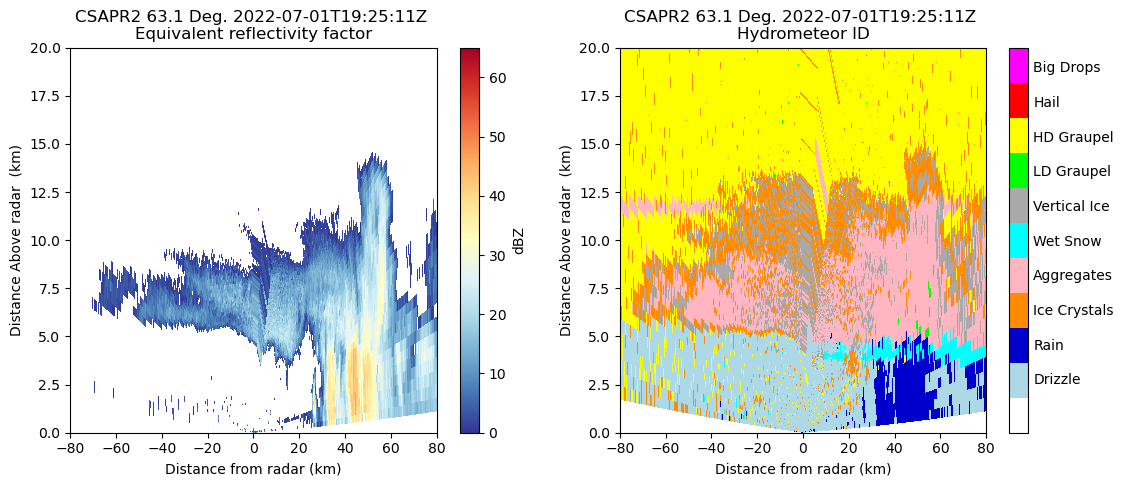

In [22]:
# Actual plotting done here
limx = [-80, 80]
limy = [0,20]
fig, ax1, ax2, display = two_panel_plot_rhi(
    radar, sweep=0, var1='reflectivity', var2='FH', vmin2=0, vmax2=10,
    cmap2=cmaphid, units2='', return_flag=True, xlim=limx, ylim=limy)
display.cbs[1] = adjust_fhc_colorbar_for_pyart(display.cbs[1])

# HID for XSACR

In [23]:
#Read in the data
sndfile = 'LCH_sounding.txt'
radarfile = 'houxsacrcfrqcM1.b1/houxsacrcfrqcM1.b1.20220701.192451.nc'
radar = pyart.io.read(radarfile)
print(radar.fields.keys())
sounding = SkewT.Sounding(sndfile)

dict_keys(['attenuation_corrected_differential_reflectivity', 'copol_correlation_coeff', 'attenuation_corrected_reflectivity_h', 'differential_phase', 'differential_reflectivity', 'censor_mask', 'mean_doppler_velocity', 'reflectivity', 'signal_to_noise_ratio_copolar_h', 'signal_to_noise_ratio_copolar_v', 'specific_differential_phase', 'spectral_width', 'specific_attenuation', 'specific_differential_attenuation'])


In [24]:
radar.metadata['scan_name']

'hsrhi'

In [25]:
dz = radar.fields['reflectivity']['data']
dr = radar.fields['differential_reflectivity']['data']
# kd = radar.fields['specific_differential_phase']['data']
rh = radar.fields['copol_correlation_coeff']['data']

So, this radar in its pre-QC format doesn't include any KDP. As this is the QC version from the radar data team, it does have this. But, lets pretend this isn't there and you only have the raw a1 level data, what would you do?
Fortunately, the csu_radartools library has a function for that!

In [26]:
def extract_unmasked_data(radar, field, bad=-32768):
    """Simplify getting unmasked radar fields from Py-ART"""
    return radar.fields[field]['data'].filled(fill_value=bad)

In [27]:
dz = extract_unmasked_data(radar, 'reflectivity')
dp = extract_unmasked_data(radar, 'differential_phase')
# Range needs to be supplied as a variable, and it needs to be the same shape as dzN, etc.
rng2d, az2d = np.meshgrid(radar.range['data'], radar.azimuth['data'])

Now that we have all our needed inputs to calculate Kdp, the function we will call is csu_kdp.calc_kdp_bringi. It returns Kdp, filtered differential phase, and standard deviation of differential phase. Input variables can be 1D (rays) or 2D (azimuth/elevation and rays). The fundamental algorithm works on a ray-by-ray basis
___
gs is the gate spacing that the radar data use, in meters. 

window is the length (km) over which to apply the phase filtering. Default is 3 km. 

thsd is the threshold to apply to the standard deviation of differential phase (deg). 

In [32]:
kd, fd, sd = csu_kdp.calc_kdp_bringi(
    dp=dp, dz=dz, rng=rng2d/1000.0, thsd=12, gs=250.0, window=5)

In [33]:
radar = add_field_to_radar_object(kd, radar, field_name='KDP', units='deg/km', 
                                   long_name='Specific Differential Phase',
                                   standard_name='Specific Differential Phase', 
                                   dz_field='reflectivity')
radar = add_field_to_radar_object(fd, radar, field_name='FDP', units='deg', 
                                   long_name='Filtered Differential Phase',
                                   standard_name='Filtered Differential Phase', 
                                   dz_field='reflectivity')
radar = add_field_to_radar_object(sd, radar, field_name='SDP', units='deg', 
                                   long_name='Standard Deviation of Differential Phase',
                                   standard_name='Standard Deviation of Differential Phase', 
                                   dz_field='reflectivity')

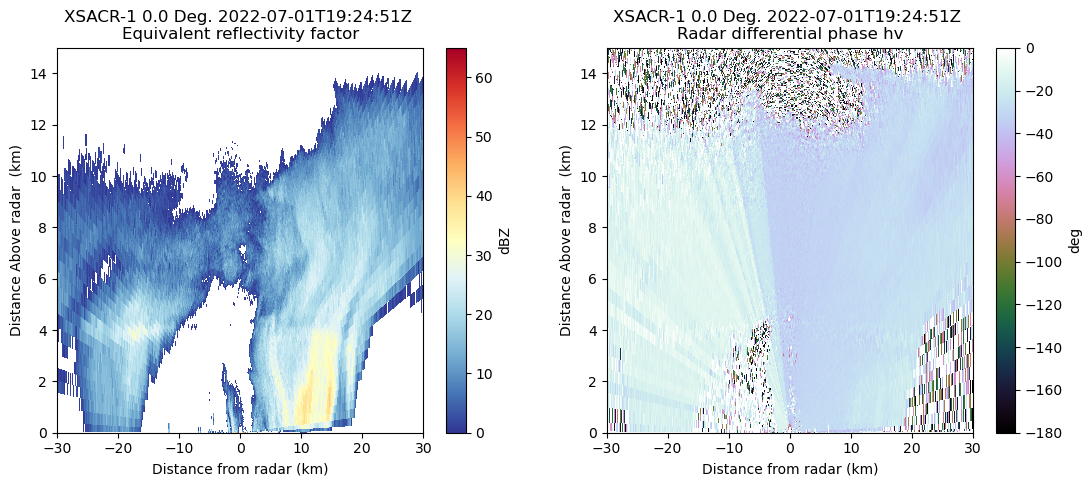

In [34]:
limx = [-30, 30]
limy = [0,15]
two_panel_plot_rhi(radar, sweep=0, var1='reflectivity', vmin1=0, vmax1=65.0, 
               cmap1='RdYlBu_r', units1='dBZ',
               var2='differential_phase', vmin2=-180, vmax2=0, 
               cmap2='cubehelix', units2='deg', 
               xlim=limx, ylim=limy)

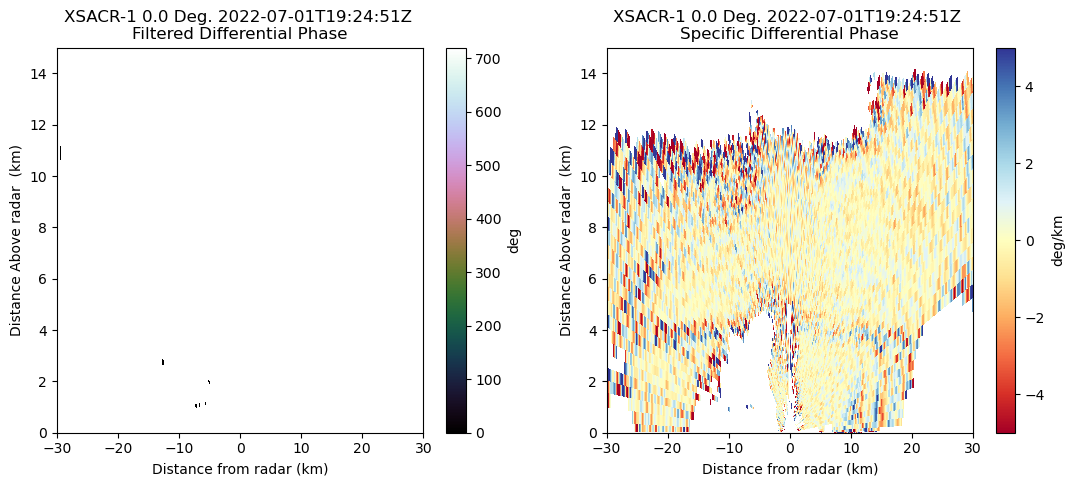

In [35]:
#Now let's see the filtered and specific differential phase fields
two_panel_plot_rhi(radar, sweep=0, var1='FDP', vmin1=0, vmax1=720, 
               cmap1='cubehelix', units1='deg',
               var2='KDP', vmin2=-5, vmax2=5, cmap2='RdYlBu', units2='deg/km', 
               xlim=limx, ylim=limy)

Great! Now that we have our KDP (even if there is very little signature for the storms in this scan), lets get back to the HID. 

In [36]:
dz = radar.fields['reflectivity']['data']
dr = radar.fields['differential_reflectivity']['data']
kd = radar.fields['KDP']['data']
rh = radar.fields['copol_correlation_coeff']['data']

In [37]:
radar_T, radar_z = interpolate_sounding_to_radar(sounding, radar)

In [38]:
scores = csu_fhc.csu_fhc_summer(dz=dz, zdr=dr, rho=rh, kdp=kd, use_temp=True, band='X',
                                T=radar_T)
fh = scores

In [39]:
radar = add_field_to_radar_object(fh, radar)


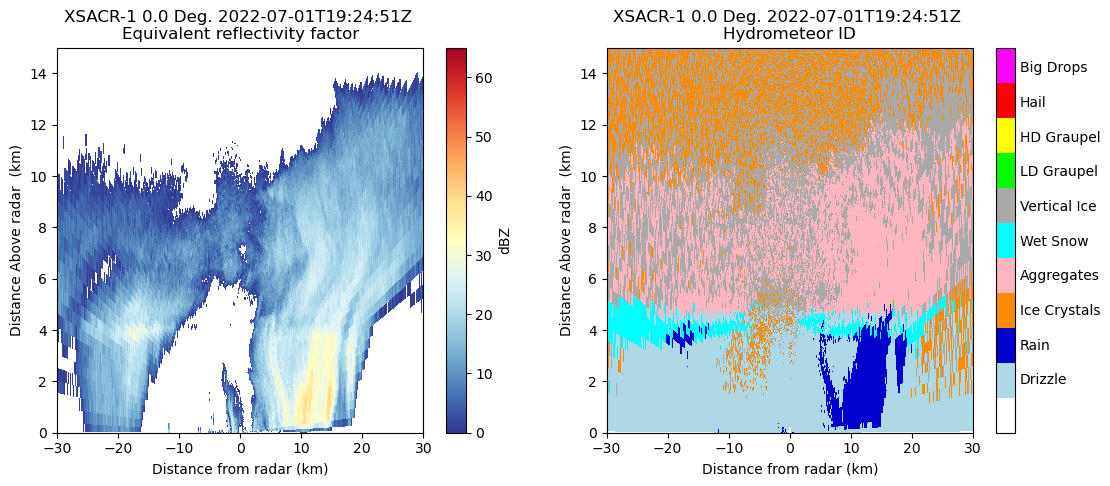

In [40]:
# Actual plotting done here
limx = [-30, 30]
limy = [0,15]
fig, ax1, ax2, display = two_panel_plot_rhi(
    radar, sweep=0, var1='reflectivity', var2='FH', vmin2=0, vmax2=10,
    cmap2=cmaphid, units2='', return_flag=True, xlim=limx, ylim=limy)
display.cbs[1] = adjust_fhc_colorbar_for_pyart(display.cbs[1])

What features do you notice are picked up in the HID?

- This could be a feature that electrical activity is occurring in the storm (aggregates).